In [51]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import torch.optim as optim
import fcn_train
import tqdm
from torch.autograd import Variable
import os
from torchvision.models.detection.transform import GeneralizedRCNNTransform
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
torch.cuda.empty_cache()

In [3]:
plt.rcParams['figure.figsize'] = [15, 7.5]

In [4]:
class ResNet_FPN_FCN(nn.Module):
    def __init__(self, resnet_fpn):
        super(ResNet_FPN_FCN, self).__init__()
        
        setattr(self, 'fpn', resnet_fpn)
        
#         self.fmap_0_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_1_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_2_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_3_score = nn.Sequential(nn.Conv2d(256, 21, 1))      
    
    def forward(self, x):
        
        fpn_out = self.fpn(x)
        
#         fmap_0 = fpn_out[0]
        fmap_1 = fpn_out[1]
        fmap_2 = fpn_out[2]
        fmap_3 = fpn_out[3]
        
#         score_0 = self.fmap_0_score(fmap_0)
        score_1 = self.fmap_1_score(fmap_1)
        score_2 = self.fmap_2_score(fmap_2)
        score_3 = self.fmap_3_score(fmap_3)
        
        self.upsample_3 = nn.UpsamplingBilinear2d(size=(fmap_2.shape[2], fmap_2.shape[3]))
        self.upsample_2 = nn.UpsamplingBilinear2d(size=(fmap_1.shape[2], fmap_1.shape[3]))
#         self.upsample_1 = nn.UpsamplingBilinear2d(size=(fmap_0.shape[2], fmap_0.shape[3]))
        self.upsample_0 = nn.UpsamplingBilinear2d(size=(x.shape[2], x.shape[3]))

        score_3_upsample = self.upsample_3(score_3)
        score_2_sum = score_2 + score_3_upsample
        score_2_upsample = self.upsample_2(score_2_sum)
        score_1_sum = score_1 + score_2_upsample
#         score_1_upsample = self.upsample_1(score_1_sum)
#         upsample_0 = score_0 + score_1_upsample
        out = self.upsample_0(score_1_sum)
        
        return out

In [35]:
class FRCNN_FCN(nn.Module):
    def __init__(self, frcnn):
        super(FRCNN_FCN, self).__init__()
        
        setattr(self, 'frcnn', frcnn)
        
#         def fpn_forward_hook(self, input, output):
#             setattr(self, "_fpn_hook", output)
        
        def layer1_fwd_hook(self, input, output):
            setattr(self, "_layer1_fwd", output)
        
        def layer2_fwd_hook(self, input, output):
            setattr(self, "_layer2_fwd", output)
        
        def layer3_fwd_hook(self, input, output):
            setattr(self, "_layer3_fwd", output)
        
        def layer4_fwd_hook(self, input, output):
            setattr(self, "_layer4_fwd", output)
        
        
        fcn_fpn = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True).fpn
        setattr(self, 'fcn_fpn', fcn_fpn)
    
#         self.frcnn.backbone.fpn.register_forward_hook(fpn_forward_hook)
        self.frcnn.backbone.body.layer1.register_forward_hook(layer1_fwd_hook)
        self.frcnn.backbone.body.layer2.register_forward_hook(layer2_fwd_hook)
        self.frcnn.backbone.body.layer3.register_forward_hook(layer3_fwd_hook)
        self.frcnn.backbone.body.layer4.register_forward_hook(layer4_fwd_hook)
        
#         fcn_upsample = nn.Sequential(*list(fcn.children())[1:])
#         setattr(self, 'fcn_upsample', fcn_upsample)
                    
#         self.fmap_0_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_1_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_2_score = nn.Sequential(nn.Conv2d(256, 21, 1))
        self.fmap_3_score = nn.Sequential(nn.Conv2d(256, 21, 1))      
    
    def forward(self, x):
        
        det_out = self.frcnn(x)
        
        layer1 =  self.frcnn.backbone.body.layer1._layer1_fwd
        layer2 =  self.frcnn.backbone.body.layer2._layer2_fwd
        layer3 =  self.frcnn.backbone.body.layer3._layer3_fwd
        layer4 =  self.frcnn.backbone.body.layer4._layer4_fwd
        
        fmaps = {0:layer1, 1:layer2, 2:layer3, 3:layer4}
        
#         fpn_out = self.frcnn.backbone.fpn._fpn_hook
        fpn_out = self.fcn_fpn(fmaps)
        
        fmap_0 = fpn_out[0]
        fmap_1 = fpn_out[1]
        fmap_2 = fpn_out[2]
        fmap_3 = fpn_out[3]
        
#         score_0 = self.fmap_0_score(fmap_0)
        score_1 = self.fmap_1_score(fmap_1)
        score_2 = self.fmap_2_score(fmap_2)
        score_3 = self.fmap_3_score(fmap_3)
        
        self.upsample_3 = nn.UpsamplingBilinear2d(size=(fmap_2.shape[2], fmap_2.shape[3]))
        self.upsample_2 = nn.UpsamplingBilinear2d(size=(fmap_1.shape[2], fmap_1.shape[3]))
#         self.upsample_1 = nn.UpsamplingBilinear2d(size=(fmap_0.shape[2], fmap_0.shape[3]))
        self.upsample_0 = nn.UpsamplingBilinear2d(size=(x.shape[2], x.shape[3]))
        
        score_3_upsample = self.upsample_3(score_3)
        score_2_sum = score_2 + score_3_upsample
        score_2_upsample = self.upsample_2(score_2_sum)
        score_1_sum = score_1 + score_2_upsample
#         score_1_upsample = self.upsample_1(score_1_sum)
#         score_0_sum = score_0 + score_1_upsample
        seg_out = self.upsample_0(score_1_sum)
        
#         seg_out = self.fcn_upsample(fpn_out)
        return (det_out, seg_out)

In [6]:
resnet_fpn = torchvision.models.detection.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
resnet_fpn.cuda()
resnet_fpn.eval()

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d()
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [7]:
# x0 = torch.rand(5,256,64,64).cuda()
# x1 = torch.rand(5,512,32,32).cuda()
# x2 = torch.rand(5,1024,16,16).cuda()
# x3 = torch.rand(5,2048,8,8).cuda()
# fmaps = {0:x0, 1:x1, 2:x2, 3:x3}
# fmaps[0].type()

In [8]:
# fpn_net = resnet_fpn.fpn
# fpn_net.cuda()

In [9]:
# fpn_net(fmaps)

In [10]:
det_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
det_model.cuda()
det_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
  

In [11]:
seg_model = ResNet_FPN_FCN(resnet_fpn)
best_model_path =  './seg_training/best_models/ResNet_FPN_FCN_best_2.pth.tar'
best_model_ckpt = torch.load(best_model_path)
seg_model.load_state_dict(best_model_ckpt['model_state_dict'])
seg_model.cuda()
seg_model.eval()

ResNet_FPN_FCN(
  (fpn): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
        (1): Bottleneck(
          (conv1): C

In [34]:
seg_model.fpn.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (layer_blocks): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (extra_blocks): LastLevelMaxPool()
)

In [76]:
frcnn_fcn = FRCNN_FCN(det_model)
# frcnn_fcn.frcnn.backbone.fpn.load_state_dict(seg_model.fpn.fpn.state_dict(), strict=False)
frcnn_fcn.fcn_fpn.load_state_dict(seg_model.fpn.fpn.state_dict())
frcnn_fcn.fmap_1_score.load_state_dict(seg_model.fmap_1_score.state_dict())
frcnn_fcn.fmap_2_score.load_state_dict(seg_model.fmap_2_score.state_dict())
frcnn_fcn.fmap_3_score.load_state_dict(seg_model.fmap_2_score.state_dict())

frcnn_fcn.cuda()
frcnn_fcn.eval()

FRCNN_FCN(
  (frcnn): FasterRCNN(
    (transform): GeneralizedRCNNTransform()
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [14]:
# frcnn_fcn.frcnn.backbone.fpn

In [15]:
# for name, parameter in frcnn_fcn.named_parameters():
#     parameter.requires_grad = False

In [77]:
img_transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    ])

In [53]:
# min_size=800
# max_size=1333
# image_mean = [0.485, 0.456, 0.406]
# image_std = [0.229, 0.224, 0.225]
# img_transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

In [39]:
def label_transform(label):
#     label = transforms.Resize(800)(label)
    label = np.array(label, dtype=np.int32)
    label[label == 255] = -1
    return torch.from_numpy(label).long()

In [18]:
train_set  = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                                download=False,
                                                year='2012',
                                                image_set='train',
                                                transform=img_transform,
                                                target_transform = label_transform)

In [19]:
train_loader = torch.utils.data.DataLoader(dataset =train_set, batch_size=1,
                                          shuffle=True, num_workers=0)

In [20]:
val_set = torchvision.datasets.VOCSegmentation(root='../datasets/',
                                              download=False,
                                              year='2012',
                                              image_set='val',
                                              transform=img_transform,
                                              target_transform = label_transform)

In [21]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1,
                                          shuffle=False, num_workers=0)

In [78]:
input = Image.open('../datasets/VOCdevkit/VOC2012/JPEGImages/2007_000323.jpg')
input = img_transform(input)
input = torch.unsqueeze(input, dim=0)
input = input.cuda()
det_out, seg_out = frcnn_fcn(input)

In [79]:
det_out

[{'boxes': tensor([[  22.9353,   23.4355,  679.1976,  794.8642],
          [ 439.3715,    3.9541, 1043.8916,  792.5530],
          [   6.3993,   20.6559,  167.9700,  769.4961],
          [   0.0000,    0.0000,  317.9951,  594.5117],
          [ 410.9085,  293.6436,  576.6082,  436.4529],
          [   0.0000,   85.9126,   88.6488,  783.9022],
          [ 348.6073,  347.9850,  668.3870,  789.4546],
          [ 533.2385,  331.0614,  566.2261,  391.5035],
          [ 531.6596,  309.8663,  576.1219,  401.4646],
          [ 349.8334,  428.0338,  606.3194,  761.5361],
          [ 481.1218,  293.8802,  583.7377,  364.9219],
          [ 329.2185,  366.3710,  607.4181,  755.9437],
          [ 944.7849,    2.9716, 1062.1644,  163.2711],
          [ 500.9688,  287.3823,  578.6158,  416.2448],
          [ 532.3708,  338.2513,  563.4083,  366.5101],
          [ 348.9664,  565.6593,  512.0958,  701.3212]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([ 1,  1, 82, 82, 77, 82

Text(0.5, 1.0, 'Resnet FPN features+FCN')

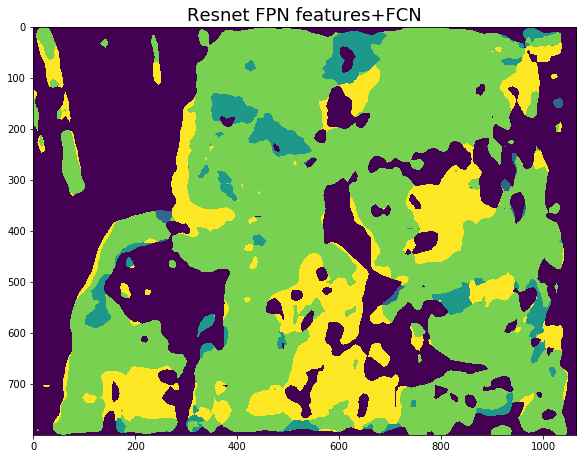

In [80]:
_, y_argmax = torch.max(seg_out, dim=1)
y_argmax = y_argmax.cpu()
seg_map = y_argmax.detach().numpy()
seg_map = np.squeeze(seg_map)
#plt.subplot(1,3,3)
plt.imshow(seg_map)
plt.title('Resnet FPN features+FCN', size=18)